In [1]:
!apt install tesseract-ocr -y
!pip install pytesseract scikit-learn opencv-python matplotlib tensorflow


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
import cv2
import os
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [3]:
def extract_text(image_path):
    try:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        text = pytesseract.image_to_string(gray)
        return text.strip()
    except Exception as e:
        print("OCR failed:", e)
        return ""


In [6]:
texts = []
labels = []

DATASET_PATH = '/content/drive/MyDrive/AI ML/dataset'

for label in os.listdir(DATASET_PATH):
    folder = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(folder): continue

    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        text = extract_text(path)
        if len(text.strip()) > 0:
            texts.append(text)
            labels.append(label)

print(f"Total samples: {len(texts)}")


Total samples: 308


In [7]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

text_model = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression(max_iter=500))
])

text_model.fit(X_train, y_train)

print("📋 Evaluation Report for Text Classifier:\n")
print(classification_report(y_test, text_model.predict(X_test)))

joblib.dump(text_model, '/content/drive/MyDrive/ocr_text_model.pkl')


📋 Evaluation Report for Text Classifier:

              precision    recall  f1-score   support

        form       0.80      0.36      0.50        11
 handwritten       0.54      0.78      0.64         9
     invoice       0.58      1.00      0.74         7
      letter       0.61      0.85      0.71        13
        memo       1.00      0.50      0.67        12
      resume       1.00      0.80      0.89        10

    accuracy                           0.69        62
   macro avg       0.76      0.71      0.69        62
weighted avg       0.77      0.69      0.69        62



['/content/drive/MyDrive/ocr_text_model.pkl']

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
classes = sorted(os.listdir(DATASET_PATH))

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load base model
base_model = MobileNetV2(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(len(classes), activation='softmax')(x)

cnn_model = Model(inputs=base_model.input, outputs=output)

# Freeze feature extractor
for layer in base_model.layers:
    layer.trainable = False

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
cnn_model.fit(train_gen, validation_data=val_gen, epochs=5)

# Save model
cnn_model.save('/content/drive/MyDrive/image_model.h5')


Found 264 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.1767 - loss: 1.9879

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 762ms/step - accuracy: 0.1852 - loss: 1.9663 - val_accuracy: 0.2333 - val_loss: 1.8676
Epoch 2/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.4665 - loss: 1.4634 - val_accuracy: 0.2667 - val_loss: 1.7896
Epoch 3/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.5664 - loss: 1.2764 - val_accuracy: 0.3167 - val_loss: 1.7590
Epoch 4/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - accuracy: 0.6560 - loss: 1.0650 - val_accuracy: 0.2833 - val_loss: 1.7156
Epoch 5/5
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.6608 - loss: 1.0277 - val_accuracy: 0.3167 - val_loss: 1.7029


In [9]:
text_model = joblib.load('/content/drive/MyDrive/ocr_text_model.pkl')
cnn_model = load_model('/content/drive/MyDrive/image_model.h5')
classes = train_gen.class_indices
idx_to_class = {v: k for k, v in classes.items()}

def predict_ensemble(image_path, weight_text=0.5):
    # OCR prediction
    text = extract_text(image_path)
    text_proba = text_model.predict_proba([text])[0]

    # CNN prediction
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = preprocess_input(np.expand_dims(img_array, axis=0))
    cnn_proba = cnn_model.predict(img_array)[0]

    # Weighted average
    final_proba = (weight_text * text_proba) + ((1 - weight_text) * cnn_proba)
    class_idx = np.argmax(final_proba)
    return idx_to_class[class_idx]


In [12]:
test_image_path = '/content/drive/MyDrive/AI ML/dataset/form/0001439080.jpg'  # change path
predicted_class = predict_ensemble(test_image_path)
print("🧠 Predicted Class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
🧠 Predicted Class: form


In [13]:
def predict_ensemble_smart(image_path):
    text = extract_text(image_path)
    text_length = len(text.strip())

    # If OCR returns good text, use more weight for text
    weight_text = 0.7 if text_length > 10 else 0.3
    return predict_ensemble(image_path, weight_text)


In [16]:
import os
import shutil
import random
from tqdm import tqdm

original_dataset = '/content/drive/MyDrive/AI ML/dataset'
train_folder = '/content/drive/MyDrive/AI ML/train'
test_folder = '/content/drive/MyDrive/AI ML/test'

split_ratio = 0.2  # 20% for test

# Create train and test folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Loop through each class
for class_name in tqdm(os.listdir(original_dataset), desc="Splitting dataset"):
    class_path = os.path.join(original_dataset, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images)

    split_index = int(len(images) * split_ratio)
    test_images = images[:split_index]
    train_images = images[split_index:]

    # Create class subfolders
    os.makedirs(os.path.join(train_folder, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_folder, class_name), exist_ok=True)

    # Copy files
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_folder, class_name, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_folder, class_name, img))

print("✅ Dataset split complete!")


Splitting dataset: 100%|██████████| 6/6 [00:02<00:00,  2.14it/s]

✅ Dataset split complete!


In [17]:
import os

true_labels = []
pred_labels = []

TEST_PATH = '/content/drive/MyDrive/AI ML/test'

for label in os.listdir(TEST_PATH):
    folder = os.path.join(TEST_PATH, label)
    if not os.path.isdir(folder): continue

    for file in os.listdir(folder):
        if not file.lower().endswith(('.jpg', '.jpeg', '.png')): continue
        path = os.path.join(folder, file)

        try:
            pred = predict_ensemble_smart(path)
            pred_labels.append(pred)
            true_labels.append(label)
        except Exception as e:
            print(f"Error on {file}: {e}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

📊 Classification Report:

              precision    recall  f1-score   support

        form       0.90      0.90      0.90        10
 handwritten       0.91      1.00      0.95        10
     invoice       0.91      1.00      0.95        10
      letter       0.90      0.90      0.90        10
        memo       1.00      0.80      0.89        10
      resume       1.00      1.00      1.00        10

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



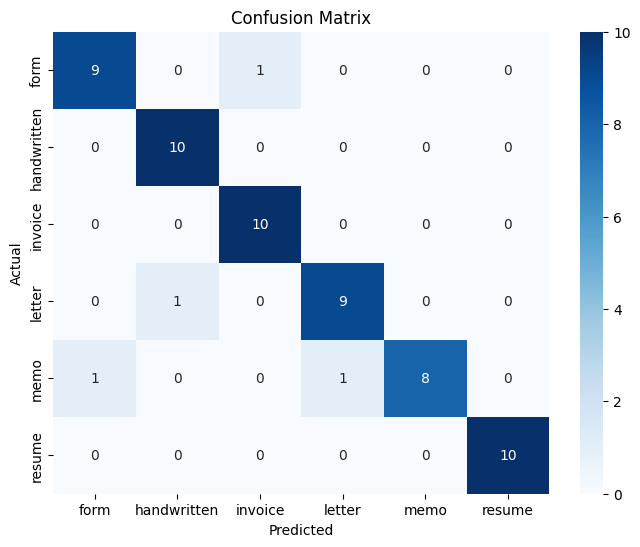

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("📊 Classification Report:\n")
print(classification_report(true_labels, pred_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=sorted(set(true_labels)))
df_cm = pd.DataFrame(cm, index=sorted(set(true_labels)), columns=sorted(set(true_labels)))

plt.figure(figsize=(8,6))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [19]:
import pandas as pd

df = pd.DataFrame({'Filename': pred_labels, 'Actual': true_labels, 'Predicted': pred_labels})
df.to_csv('/content/drive/MyDrive/predictions.csv', index=False)


In [20]:
joblib.dump(text_model, '/content/drive/MyDrive/AI ML/ocr_text_model.pkl')
cnn_model.save('/content/drive/MyDrive/AI ML/image_model.h5')
